In [1]:
import configparser
from model.model import Model
from dataprovider.era5 import ERA5 as DataProvider
from tqdm import tqdm
import datetime
import numpy as np
import matplotlib.pyplot as plt  

In [2]:
MODEL = 'lsntp'
DATASET = 'era5'
config_file = './{}_{}.config'.format(MODEL, DATASET)
config = configparser.ConfigParser()
config.read(config_file)

['./lsntp_era5.config']

In [3]:
model = Model(config)

In [4]:
network = model.get_model()

self.lsntp_downsample: True True


In [5]:
model.param_counter()

Number of params: 5.99M


In [6]:
network

DataParallel(
  (module): Network(
    (encoder): Encoder(
      (conv2d): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2))
      (convrnn1): LSConvLSTM(
        (cell): LSConvLSTMCell(
          (conv): LSConv(
            (spatial_atten_block): NodeBasedAttentionModule(
              (spatail_atten): Sequential(
                (0): Conv2d(129, 129, kernel_size=(1, 1), stride=(1, 1))
                (1): GroupNorm(1, 129, eps=1e-05, affine=True)
                (2): ReLU(inplace=True)
                (3): Conv2d(129, 129, kernel_size=(1, 1), stride=(1, 1))
                (4): GroupNorm(1, 129, eps=1e-05, affine=True)
                (5): ReLU(inplace=True)
                (6): Conv2d(129, 129, kernel_size=(1, 1), stride=(1, 1))
                (7): Sigmoid()
              )
            )
          )
        )
      )
      (convrnn2): LSConvLSTM(
        (cell): LSConvLSTMCell(
          (conv): LSConv(
            (spatial_atten_block): NodeBasedAttentionModule(
              (spata

In [7]:
dataprovider = DataProvider(config)
train_loader = dataprovider.train_loader()
validate_loader = dataprovider.validate_loader()
test_loader = dataprovider.test_loader()

In [8]:
model_save_loss = float("inf")
epochs = int(config['model']['epoch'])
resume_checkpoint = config['model']['resume_checkpoint']
if resume_checkpoint == '':
    start_epoch = 1
else:
    start_epoch = model.load()
start_epoch

1

In [9]:
starttime = datetime.datetime.now()
print('training start:', starttime)

training start: 2022-06-12 19:37:56.510005


In [10]:
# for epoch in range(start_epoch, epochs+1):
#     print('epochs [%d/%d]' % (epoch, epochs))
#     # train
#     train_loss = 0
#     for batch_idx,input_index,target_index, in tqdm(train_loader) :
#         train_loss += model.train(dataprovider.train_vlidate_data, input_index, target_index)
    
#     #validate
#     validata_loss = 0
#     for batch_idx,input_index,target_index, in tqdm(validate_loader) :
#         validata_loss += model.validate(dataprovider.train_vlidate_data, input_index, target_index)
    
#     if model_save_loss > validata_loss:
#         model.save(epoch, 'best_model.pth')
#         model_save_loss = validata_loss
    
#     model.save(epoch)   
#     print('train_loss: %.8f val_loss: %.8f' % (train_loss, validata_loss))

In [11]:
endtime = datetime.datetime.now()
print('training end:', endtime)

training end: 2022-06-12 19:37:56.635078


In [12]:
model.load('best_model.pth')

loaded model successfully


66

In [13]:
mae, mse, ssim, psnr, counter = model.test(dataprovider.test_data, test_loader, dataprovider.test_nomalizer)

100%|██████████| 35/35 [01:59<00:00,  3.41s/it]


In [14]:
timestep = mae.shape[0]

In [15]:
timesteps=[i for i in range(1,timestep+1)]
maes=[np.mean(mae[i])/counter for i in range(0, timestep)]
rmse=[np.sqrt(np.mean(mse[i])/counter) for i in range(0, timestep)]
ssims=[np.mean(ssim[i])/counter for i in range(0, timestep)]
psnrs=[np.mean(psnr[i])/counter for i in range(0, timestep)]

In [16]:
np.mean(maes), np.mean(rmse), np.mean(ssims), np.mean(psnrs)

(0.8963546645690629, 1.2575297038581013, 0.8839714766177647, 46.67339458525072)

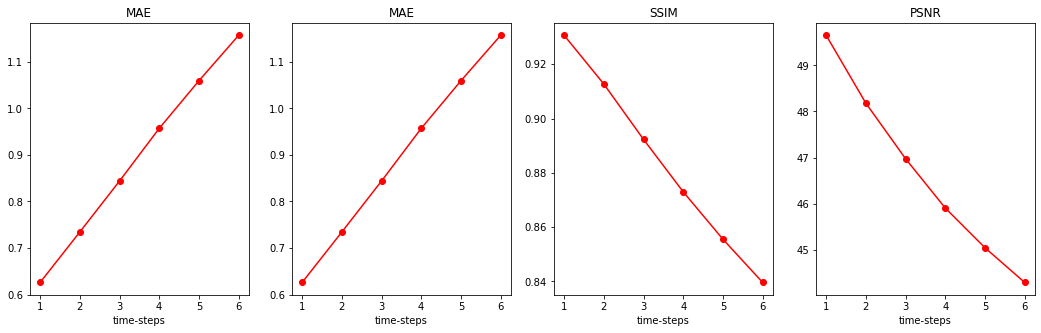

In [17]:
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
axes[0].plot(timesteps,maes,'ro-',label='GS-ConvLSTM')
axes[0].set_title('MAE')
axes[0].set_xlabel('time-steps')
axes[1].plot(timesteps,maes,'ro-',label='GS-ConvLSTM')
axes[1].set_title('MAE')
axes[1].set_xlabel('time-steps')
axes[2].plot(timesteps,ssims,'ro-',label='GS-ConvLSTM')
axes[2].set_title('SSIM')
axes[2].set_xlabel('time-steps')
axes[3].plot(timesteps,psnrs,'ro-',label='GS-ConvLSTM')
axes[3].set_title('PSNR')
axes[3].set_xlabel('time-steps')
plt.show()